## Compare SVC in the case of binary class (Sell, Buy)

In [1]:
import sys
import os
from pathlib import Path

import numpy as np

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] / "src")


if module_path not in sys.path:
    sys.path.append(module_path)
import optuna
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from utility_functions import (
    backtest_strategy,
    display_report,
    objective_svc,
    plot_strategy,
    select_threshold,
)

In [2]:
metric = "precision"
test_size = 199

In [3]:
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [4]:
target = pd.read_csv("../data/processed/target_df.csv", parse_dates=True, index_col=0)[
    "target"
]

In [5]:
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [6]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [7]:
interest_rate = wk_df["r"].values

## Baseline SVC Classifier without new data + r

In [8]:
orig_df = ml_df[
    [
        "UNDERLYING_LAST",
        "STRIKE",
        "C_LAST",
        "C_BID",
        "C_ASK",
        "C_IV",
        "C_VOLUME",
        "diff_date",
    ]
].copy()

In [9]:
orig_df["r"] = interest_rate

### Split dataset

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df,
    target.values.flatten(),
    test_size=test_size,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [11]:
# Set hash seed for reproducibility
hashseed = os.getenv("PYTHONHASHSEED")
os.environ["PYTHONHASHSEED"] = "0"
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=1968, n_startup_trials=0),
)
study.optimize(
    lambda trial: objective_svc(trial, X_train, y_train, metric),
    n_trials=150,
    timeout=600,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Restore hash seed
if hashseed is not None:
    os.environ["PYTHONHASHSEED"] = hashseed

[I 2024-02-14 00:06:48,847] A new study created in memory with name: no-name-4043dd59-c809-44b2-9ff7-2336ba2361c9


[I 2024-02-14 00:07:02,200] Trial 0 finished with value: 0.5338324799748283 and parameters: {'kernel': 'poly', 'degree': 4, 'C': 58.246152254253985, 'gamma': 'auto', 'shrinking': False}. Best is trial 0 with value: 0.5338324799748283.
[I 2024-02-14 00:07:16,266] Trial 1 finished with value: 0.5326460797283645 and parameters: {'kernel': 'poly', 'degree': 4, 'C': 88.76782521053377, 'gamma': 'auto', 'shrinking': False}. Best is trial 0 with value: 0.5338324799748283.
[I 2024-02-14 00:07:19,462] Trial 2 finished with value: 0.5438270148459724 and parameters: {'kernel': 'poly', 'degree': 4, 'C': 9.624948954756583, 'gamma': 'auto', 'shrinking': False}. Best is trial 2 with value: 0.5438270148459724.
[I 2024-02-14 00:07:20,130] Trial 3 finished with value: 0.5386951731605999 and parameters: {'kernel': 'rbf', 'degree': 6, 'C': 0.14319122941732743, 'gamma': 'scale', 'shrinking': True}. Best is trial 2 with value: 0.5438270148459724.
[I 2024-02-14 00:07:21,411] Trial 4 finished with value: 0.530

Number of finished trials: 150
Best trial:
  Value: 0.6304975839670013
  Params: 
    kernel: poly
    degree: 5
    C: 0.06156301068957606
    gamma: scale
    shrinking: True


In [12]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", StandardScaler()),
        (
            "clf",
            SVC(**trial.params | {"random_state": 1968, "probability": True}),
        ),
    ]
)

In [13]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scaler', StandardScaler()),
                ('clf',
                 SVC(C=0.06156301068957606, degree=5, kernel='poly',
                     probability=True, random_state=1968))])

In [14]:
# In-sample score
pipe.score(X_train, y_train)

0.5706304868316041

In [15]:
# Best threshold given a 5% of maximum false positive rate
threshold = select_threshold(pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=0.05)
print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.48


In [16]:
# Use the threshold to make predictions
predictions = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

In [17]:
pipe.score(X_test, y_test)

0.49246231155778897

              precision    recall  f1-score   support

           0       0.45      0.18      0.26        98
           1       0.50      0.78      0.61       101

    accuracy                           0.49       199
   macro avg       0.47      0.48      0.43       199
weighted avg       0.47      0.49      0.44       199



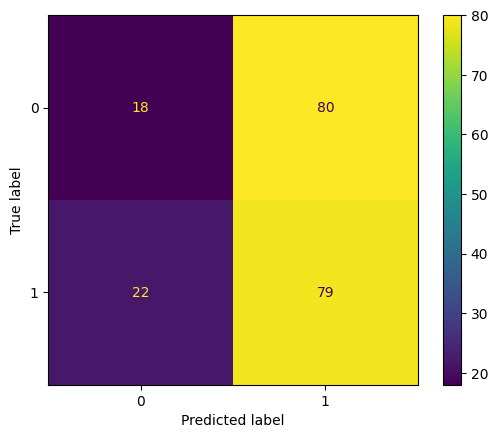

In [18]:
display_report(y_test, predictions)

In [19]:
compare_df = pd.DataFrame(predictions, columns=["bare_rf_pred_out"])

### Backtesting

In [20]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [21]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2023-01-04,0,384.0,7.46,2023-01-27,405.679993,0.000000,14.219993,0.000000,14.219993
2023-01-05,0,379.0,8.50,2023-01-27,405.679993,0.000000,18.179993,0.000000,32.399985
2023-01-06,0,388.0,7.72,2023-01-27,405.679993,0.000000,9.959993,0.000000,42.359978
2023-01-09,0,388.0,7.46,2023-01-27,405.679993,0.000000,10.219993,0.000000,52.579971
2023-01-11,0,395.0,9.11,2023-02-03,412.350006,0.000000,8.240006,0.000000,60.819977
...,...,...,...,...,...,...,...,...,...
2023-12-21,1,473.0,6.07,2024-01-12,476.679993,-2.390007,-2.390007,279.769840,404.169901
2023-12-22,1,474.0,5.70,2024-01-12,476.679993,-3.020007,-3.020007,276.749833,401.149894
2023-12-27,1,476.0,6.19,2024-01-19,482.429993,0.239993,0.239993,276.989825,401.389886


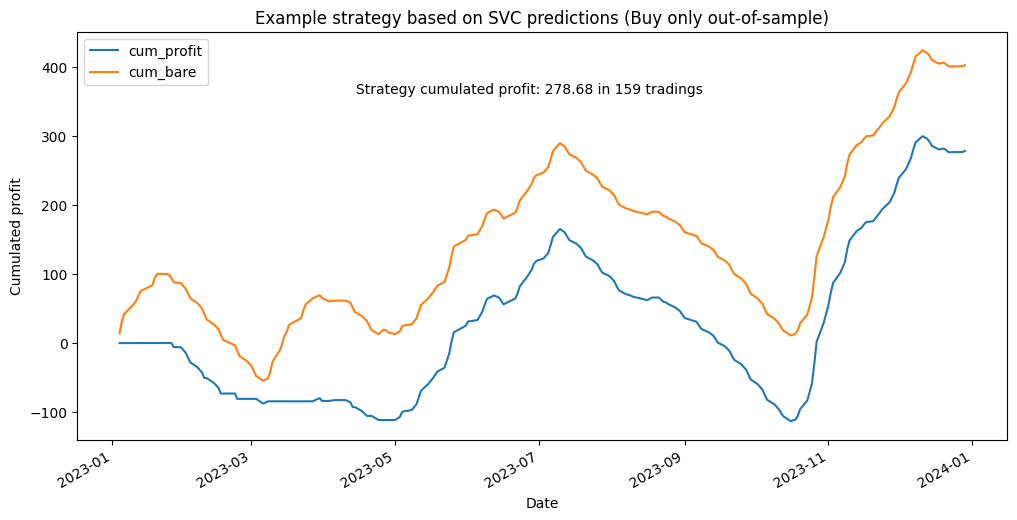

In [22]:
plot_strategy(strategy_df, "SVC", "(Buy only out-of-sample)")

In [23]:
compare_df["cum_profit_out"] = strategy_df["cum_profit"].values

## SVC with data from MC simulation and additional features

In [24]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike"], axis=1),
    ),
    axis=1,
)

In [25]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

### Split dataset

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df,
    target.values.flatten(),
    test_size=test_size,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [27]:
# Set hash seed for reproducibility
hashseed = os.getenv("PYTHONHASHSEED")
os.environ["PYTHONHASHSEED"] = "0"
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=1968, n_startup_trials=0),
)
study.optimize(
    lambda trial: objective_svc(trial, X_train, y_train, metric),
    n_trials=150,
    timeout=1200,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Restore hash seed
if hashseed is not None:
    os.environ["PYTHONHASHSEED"] = hashseed

[I 2024-02-14 00:08:53,771] A new study created in memory with name: no-name-98bc8a49-d592-4934-9fde-cf600016022f


[I 2024-02-14 00:08:57,565] Trial 0 finished with value: 0.5483136650960997 and parameters: {'kernel': 'poly', 'degree': 4, 'C': 58.246152254253985, 'gamma': 'auto', 'shrinking': False}. Best is trial 0 with value: 0.5483136650960997.
[I 2024-02-14 00:09:01,089] Trial 1 finished with value: 0.5488718034716523 and parameters: {'kernel': 'poly', 'degree': 4, 'C': 88.76782521053377, 'gamma': 'auto', 'shrinking': False}. Best is trial 1 with value: 0.5488718034716523.
/Users/andrea/Desktop/WQU-Course/MScFE/Capstone/wqu_capstone/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/andrea/Desktop/WQU-Course/MScFE/Capstone/wqu_capstone/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-define

Number of finished trials: 150
Best trial:
  Value: 0.6490126089173884
  Params: 
    kernel: rbf
    degree: 4
    C: 95.10406935534262
    gamma: scale
    shrinking: True


In [28]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", StandardScaler()),
        (
            "clf",
            SVC(**study.best_params | {"random_state": 1968, "probability": True}),
        ),
    ]
)

In [29]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scaler', StandardScaler()),
                ('clf',
                 SVC(C=95.10406935534262, degree=4, probability=True,
                     random_state=1968))])

In [30]:
# In-sample score
pipe.score(X_train, y_train)

0.8132482043096568

In [31]:
# Best threshold given a 5% of maximum false positive rate
threshold = select_threshold(pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=0.05)
print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.60


In [32]:
# Use the threshold to make predictions
predictions = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

In [33]:
pipe.score(X_test, y_test)

0.5226130653266332

              precision    recall  f1-score   support

           0       0.49      0.98      0.66        98
           1       0.50      0.02      0.04       101

    accuracy                           0.49       199
   macro avg       0.50      0.50      0.35       199
weighted avg       0.50      0.49      0.34       199



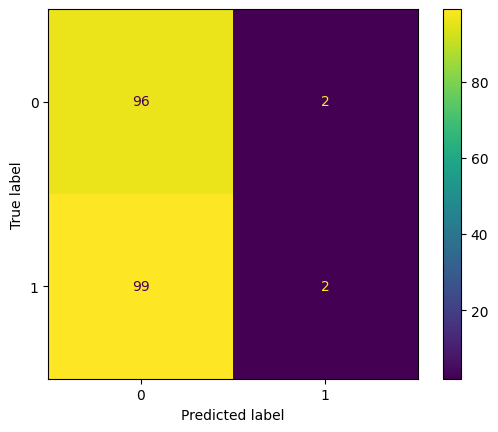

In [34]:
display_report(y_test, predictions)

In [35]:
compare_df["mmar_rf_pred_out"] = predictions

### Backtesting

In [36]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [37]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2023-01-04,0,384.0,7.46,2023-01-27,405.679993,0.000000,14.219993,0.000000,14.219993
2023-01-05,1,379.0,8.50,2023-01-27,405.679993,18.179993,18.179993,18.179993,32.399985
2023-01-06,0,388.0,7.72,2023-01-27,405.679993,0.000000,9.959993,18.179993,42.359978
2023-01-09,0,388.0,7.46,2023-01-27,405.679993,0.000000,10.219993,18.179993,52.579971
2023-01-11,0,395.0,9.11,2023-02-03,412.350006,0.000000,8.240006,18.179993,60.819977
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.000000,-2.390007,21.790020,404.169901
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.000000,-3.020007,21.790020,401.149894
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.000000,0.239993,21.790020,401.389886


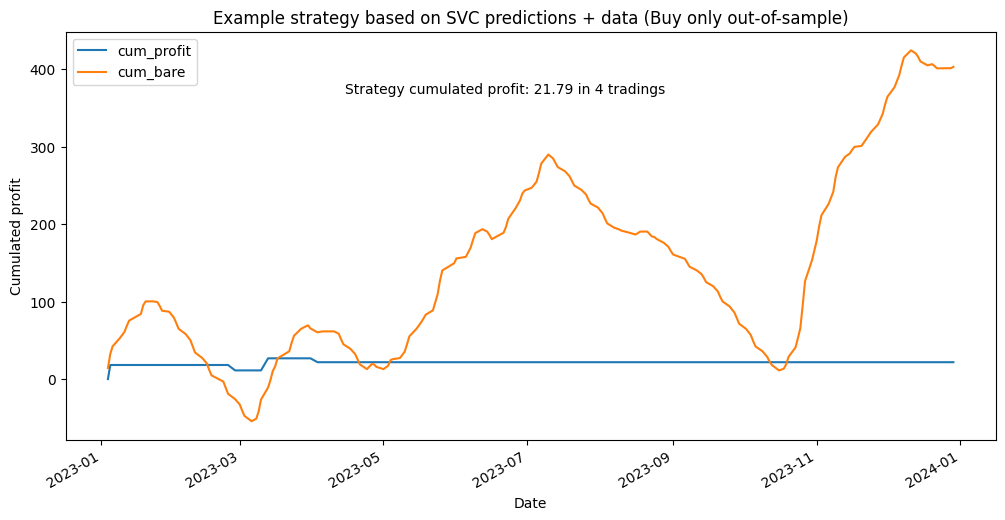

In [38]:
plot_strategy(strategy_df, "SVC", "+ data (Buy only out-of-sample)")

In [39]:
compare_df["mmar_cum_profit_out"] = strategy_df["cum_profit"].values
compare_df["mmar_cum_bare_out"] = strategy_df["cum_bare"].values

## Compare the two predictions

In [40]:
mask_out = (compare_df["bare_rf_pred_out"] - compare_df["mmar_rf_pred_out"]).astype(
    bool
)

In [41]:
# Compare out of sample preds
compare_df[mask_out]

,bare_rf_pred_out,cum_profit_out,mmar_rf_pred_out,mmar_cum_profit_out,mmar_cum_bare_out
1,0,0.000000,1,18.179993,32.399985
10,1,0.140009,0,18.179993,100.370023
13,1,-5.889982,0,18.179993,88.240052
15,1,-13.539982,0,18.179993,79.330062
16,1,-20.429982,0,18.179993,72.440062
...,...,...,...,...,...
194,1,279.769840,0,21.790020,404.169901
195,1,276.749833,0,21.790020,401.149894
196,1,276.989825,0,21.790020,401.389886
197,1,276.959818,0,21.790020,401.359879


In [42]:
compare_df[mask_out].shape

(163, 5)

In [43]:
compare_df.sum(axis=0)

bare_rf_pred_out         159.000000
cum_profit_out          5480.103445
mmar_rf_pred_out           4.000000
mmar_cum_profit_out     4188.742754
mmar_cum_bare_out      28399.674850
dtype: float64

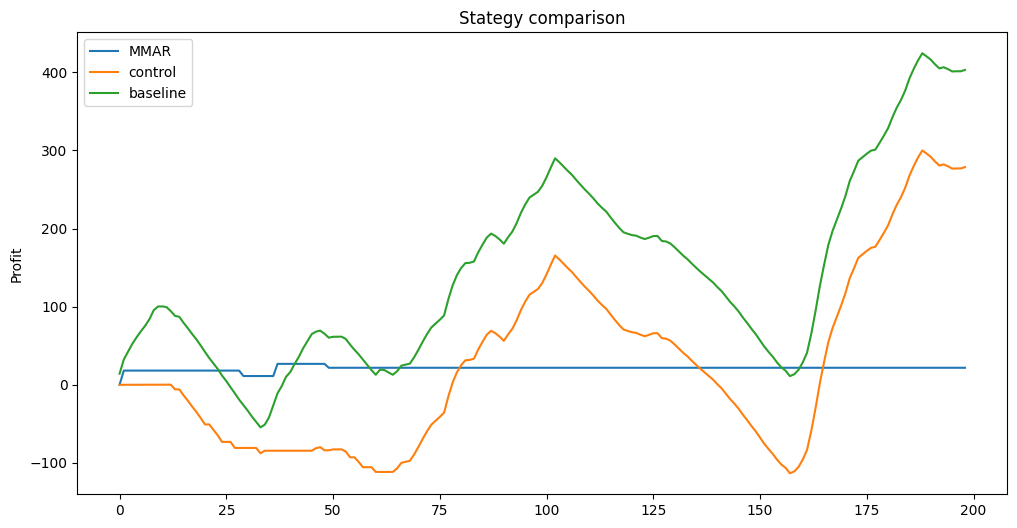

In [45]:
compare_df[["mmar_cum_profit_out", "cum_profit_out", "mmar_cum_bare_out"]].rename(
    {
        "mmar_cum_profit_out": "MMAR",
        "cum_profit_out": "control",
        "mmar_cum_bare_out": "baseline",
    },
    axis=1,
).plot(figsize=(12, 6), title="Stategy comparison", ylabel="Profit")